In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [1]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [2]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

pip install tensorflow-addons
import tensorflow_addons as tfa

Mounted at /content/drive


In [4]:
# # import os
os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/CDV


In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
from tools.misc_tools import create_CDV_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as RNN_LSTM

In [7]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [8]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [9]:
print(tf.test.gpu_device_name())
print(tf.__version__)


2.8.2


# Lorenz System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_esn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '001'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_esn/rnn_000'

    # reading simulation parameters
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']

In [11]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [12]:
n = len(boundary_idx_arr)

# Autoencoder

In [13]:
from tools.ae_v3 import Autoencoder

In [14]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
ae_net = Autoencoder(12, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [16]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

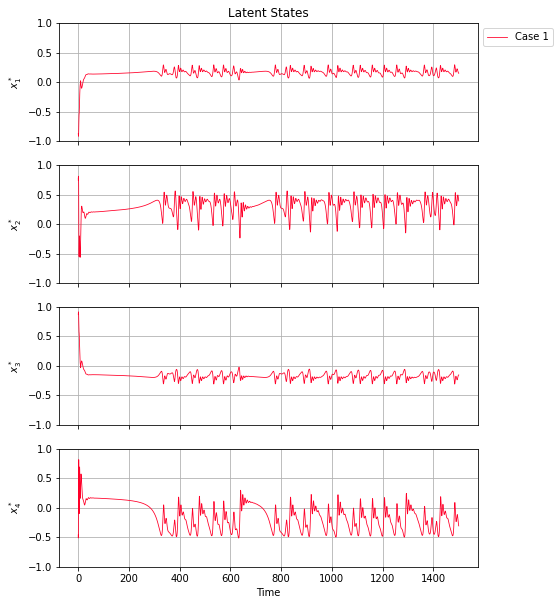

In [17]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    all_data,
    delta_t,
    params_mat,
    # xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10,
    legend_bbox_to_anchor=[1,1],
    save_config_path=None
)

In [18]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# LSTM

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.1
    T_sample_input = 30
    T_sample_output = 30
    T_offset = dt_rnn
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state':init_state,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'normalize_flag':normalize_flag
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'N':N,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [20]:
initial_t0 = np.array([400])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = (initial_t0[i] + 0.25*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    begin_idx = boundary_idx_arr[i]
    len_relevant_idx += begin_idx - initial_idx[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [21]:
data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output, num_samples = create_data_for_RNN(
    latent_states_all[relevant_idx],
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr-initial_idx,
    delta_t,
    params=params,
    return_numsamples=True)

In [22]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 1000
    patience = 20  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [23]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [24]:
idx = np.arange(num_samples)
# np.random.shuffle(idx)
boundary = int(np.round(
    (1-test_split) * num_samples
))

# defining shapes
training_input_shape = [boundary*len(boundary_idx_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [boundary*len(boundary_idx_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

for i in range(len(boundary_idx_arr)):
    np.random.shuffle(idx)

    training_data_rnn_input[i*boundary:(i+1)*boundary] = data_rnn_input[i*num_samples + idx[0:boundary]]
    training_data_rnn_output[i*boundary:(i+1)*boundary] = data_rnn_output[i*num_samples + idx[0:boundary]]

    testing_data_rnn_input[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_input[i*num_samples + idx[boundary:]]
    testing_data_rnn_output[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_output[i*num_samples + idx[boundary:]]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [54]:
res_size = 256
spectral_rad = 0.6

ESN_layer = tfa.layers.ESN(
    units=res_size,
    spectral_radius=spectral_rad,
    return_sequences=True
)
ESN_layer.trainable = False

In [55]:
training_data_rnn_input[0].shape

(300, 4)

In [56]:
ESN_input = tf.keras.Input(shape=training_data_rnn_input[0].shape)
ESN_output = ESN_layer(ESN_input)
ESN_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        training_data_rnn_input[0].shape[-1],
        activation=None,
        kernel_regularizer=tf.keras.regularizers.L2(0.001)
    )
)(ESN_output)
ESN_model = Model(ESN_input, ESN_output)

In [ ]:
val_loss_hist = []
train_loss_hist = []

In [88]:
ESN_model.compile(loss=losses.MeanSquaredError())
history = ESN_model.fit(training_data_rnn_input, training_data_rnn_output,
    epochs=1,
    batch_size=32,
    validation_split=val_split/(train_split+val_split),
    # callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
    # verbose=1
)
val_loss_hist.extend(history.history['val_loss'])
train_loss_hist.extend(history.history['loss'])

2675/2675 [==============================] - 367s 137ms/step - loss: 8.9244e-04 - val_loss: 8.8176e-04


data_idx : 10158


Text(0.5, 1.0, 'Latent States')

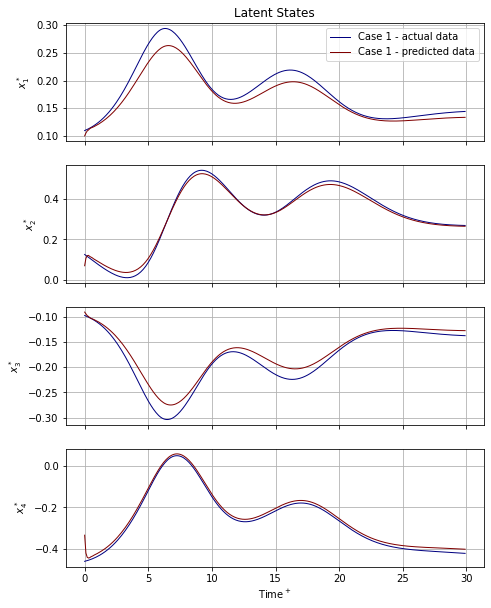

In [86]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = ESN_model.predict(data_in[data_idx:data_idx+1, :, :])

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_1$', '$x^*_2$', '$x^*_3$', '$x^*_4$', '$x^*_5$', '$x^*_6$']

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
# plt.figlegend(
#     handles=mpl_ax_artist_list[0:n],
#     # bbox_to_anchor=[1.1,0.85],
#     loc=legend_loc,
#     bbox_to_anchor=legend_bbox_to_anchor,
#     ncol=ncols,
#     markerscale=legend_markerscale
# )
ax[0].legend(
    # handles=mpl_ax_artist_list[0:n],
    # bbox_to_anchor=[1.1,0.85],
    loc='best',
    # bbox_to_anchor=legend_bbox_to_anchor,
    ncol=ncols,
    # markerscale=legend_markerscale
)
# fig.suptitle(r'Latent States', size=12)
ax[0].set_title(r'Latent States', size=12)

data_idx : 744


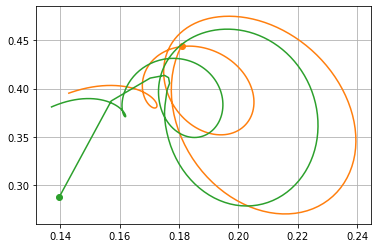

In [87]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 10
print('data_idx : {}'.format(data_idx))

### initial point
# plt.plot(data_in[data_idx, :, 0], data_in[data_idx, :, 1], 'o')

### actual trajectory
plt.plot(data_out[data_idx, 0, 0], data_out[data_idx, 0, 1], 'o', color='C1')
plt.plot(data_out[data_idx, :, 0], data_out[data_idx, :, 1], 'C1')

### predicted trajectory
prediction = ESN_model.predict(data_in[data_idx:data_idx+1, :, :])
# plt.plot([data_in[data_idx, :, 0], ].extend(prediction[0, :, 0]), [data_in[data_idx, :, 1], ].extend(prediction[0, :, 1]))
plt.plot(prediction[0, :, 0], prediction[0, :, 1], color='C2')
plt.plot(prediction[0, 0, 0], prediction[0, 0, 1], 'o', color='C2')

plt.grid(True)
plt.show()

In [ ]:
data_out[data_idx].shape